In [90]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import re

from geopy import distance
from tqdm import tqdm_notebook
from scipy.spatial.distance import euclidean
from sklearn.metrics import pairwise_distances

% matplotlib inline

In [96]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
from utils.postcodedata import read_postcode_data

In [97]:
from agents.agents import Survivor, Removed, Zombie

from utils.simulation_utils import move_one_random_step, \
                                   find_all_zombie_positions, \
                                   find_all_survivors_positions, \
                                   inherit_zombie_attributes, \
                                   inherit_survivor_attributes, \
                                   find_pairwise_distances, \
                                   find_matches, \
                                   run_duels

In [20]:
# Read postcode data
path = r"data/postcodes/postcodes_data.csv"
df = read_postcode_data(path)

In [32]:
# Dundee Bounding Box
min_lon = -3.072711
max_lon = -2.921649
min_lat = 56.4513
max_lat = 56.48412

# Filter on Dundee
dundee = df[(df['Latitude'] > min_lat) & 
            (df['Latitude'] < max_lat) &
            (df['Longitude'] > min_lon) &
            (df['Longitude'] < max_lon)]

In [45]:
# https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/articles/overviewoftheukpopulation/july2017

test = np.random.normal(loc=40, scale=20, size = 80000)


0.104325

In [59]:
# pd.read_csv("data/SpeedAge.csv")

In [61]:
# https://www.livescience.com/59289-why-men-run-faster-than-women.html
#  Usain Bolt did it in 9.58 seconds, versus the late 
#     Florence Griffith Joyner's time of 10.49 seconds.

(10.49-9.58)/10.49

0.08674928503336513

In [33]:
# Create population dictionary, everybody is a survivor

top = dundee['Persons'].sum()

population = []

available_index = 0

for row in dundee.itertuples():
    
    if row.Persons == 0:
        pass 
    
    else:
        for person in range(row.Persons):
            
            available_index += 1
    
            survivor = Survivor()
    
            # Assign a random speed
            survivor.speed = np.random.randn()
            # Assign a random age
            survivor.age = np.random.randn()
            # Assign a random sex 
            survivor.sex = np.random.choice(['M', 'F'])
            # Assign latitude and longitude
            survivor.latitude = row.Latitude
            survivor.longitude = row.Longitude
    
            person_dict = {'id': available_index, 
                           'type': survivor}
            population.append(person_dict)


In [34]:
# After initilizing the population infect a random person

np.random.seed(42)

idx_first_infected = np.random.choice(range(len(population)), size = 5)
idx_first_infected

# Zombify first infected person

for idx in idx_first_infected:
    first_inf_lat = population[idx]['type'].latitude
    first_inf_lon = population[idx]['type'].longitude

    population[idx]['type'] = Zombie()
    population[idx]['type'].latitude = first_inf_lat
    population[idx]['type'].longitude = first_inf_lon

In [35]:
idx_first_infected

array([15795,   860, 76820, 54886,  6265])

(array([ 555.,  741., 1183., 1488., 1539., 1238.,  747.,  327.,  138.,
          44.]),
 array([10., 15., 20., 25., 30., 35., 40., 45., 50., 55., 60.]),
 <a list of 10 Patch objects>)

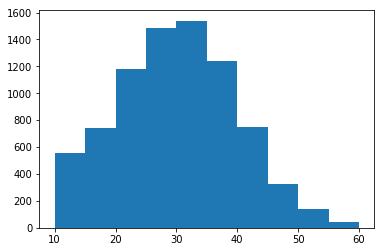

In [88]:
1.40 * 3600

# TODO - randomize how much of the hour they will walk
plt.hist(np.clip(np.random.normal(loc=30, scale=10, size = 8000), a_min = 10, a_max = 60))

In [99]:
# Start Simulation

# Move each person 1 step

idle_probability = 0.5
km = 1

for time_step in range(1):
    
    for p in tqdm_notebook(population):
        
        if p['type'].__str__() in ['Survivor', 'Zombie']:
            
            lat_s, lon_s = p['type'].latitude, p['type'].longitude
            
            dist, lat_n, lon_n = move_one_random_step(lat_s, lon_s, km)
            
            #TODO don't let them go out of the bounding box
            
            # Assign new position to person, store old position in path variable
            
            p['type'].path.append((lat_s, lon_s))
            p['type'].latitude = lat_n
            p['type'].longitude = lon_n
            
    # After all the population has made a move check who is close
    # to a zombie
    
    zombies, survivors, matches = find_pairwise_distances(population)
    
    # Now that we have far is each player from each other
    # find the pairs that have less than 25 meters distance
    
    threshold_distance = 0.013/40
    
    meetings = find_matches(matches, threshold_distance)
#     print(meetings)
    
    dead_survivors, dead_zombies = run_duels(meetings)
#     print(dead_zombies)
    
    
    for zs in dead_zombies:

        idx = zs[1][0]
        zombie_idx = zombies[idx][0]
        player = population[zombie_idx-1]['type']

        new_state = inherit_zombie_attributes(player)
        population[zombie_idx-1]['type'] = new_state
        
        
    for ds in dead_survivors:
    
        idx = ds[1][1]
        surv_idx = survivors[idx][0]
        player = population[surv_idx-1]['type']

        new_state = inherit_survivor_attributes(player)
        population[surv_idx-1]['type'] = new_state


In [102]:
print(dead_zombies)

[(-1, (0, 8648)), (-1, (0, 10105)), (-1, (1, 11565)), (-1, (1, 48038)), (-1, (2, 23222)), (-1, (2, 49605)), (-1, (3, 4112)), (-1, (3, 66623)), (-1, (4, 59356)), (-1, (4, 65650)), (-1, (4, 75614))]


In [100]:
len(list(filter(lambda x: x['type'].__repr__() == 'Removed', population)))

5

In [101]:
len(list(filter(lambda x: x['type'].__repr__() == 'Zombie', population)))

13

In [447]:
for i in find_all_zombie_positions(population):
    
    pos = (i['type'].latitude, i['type'].longitude)
    print((i['type'].latitude, i['type'].longitude))
    
np.array([pos, pos]).shape

(56.46441768094986, -3.008499506778434)


(2, 2)

In [309]:
import folium

centroid = np.median(dundee['Longitude']), np.median(dundee['Latitude'])
m = folium.Map(centroid, zoom_start=13)

# points = list(zip(dundee['Longitude'], dundee['Latitude']))

for point in points:
    
    folium.CircleMarker(point, radius = 2.5).add_to(m)


# for row in df.sort_values(by='local_time').itertuples():
    
#     point = (row.latitude, row.longitude)
#     points.append(point)
#     folium.CircleMarker(point, radius = 2.5).add_to(m)

# folium.Marker(list(zip(dundee['Latitude'], dundee['Longitude']))).add_to(m)
#     folium.Marker(points[-1], icon=folium.Icon(color='red')).add_to(m)

In [310]:
m

https://www.healthline.com/health/exercise-fitness/average-walking-speed#average-speed-by-age

Age	Meters/second	Miles/hour
20 to 29	1.34 to 1.36	3.0 to 3.04
30 to 39	1.34 to 1.43	3.0 to 3.2
40 to 49	1.39 to 1.43	3.11 to 3.2
50 to 59	1.31 to 1.43	2.93 to 3.2
60 to 69	1.24 to 1.34	2.77 to 3.0
70 to 79	1.13 to 1.26	2.53 to 2.82
80 to 89	.94 to .97	2.10 to 2.17


In [52]:
def average_speeds():
    
    b_0_10 = list(np.arange(0,11))
    sp = np.repeat(0.94, len(b_0_10))
    
    b_11_20 = list(np.arange(11,21))
    sp
    
    return b_0_10, sp

average_speeds()

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 array([0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94]))